In [90]:
# Gradient Boosting Model
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [91]:
master_df = pd.read_csv('master.csv')
data = master_df.copy()

columns_to_check = ['Day of Week', 'feelslike', 'precip', 'snowdepth', 
          'windgust', 'windspeed', 'solarradiation', 'solarenergy', 
          'uvindex', 'moonphase', 'Holiday', 'cloudcover']

missing_values_count = data[columns_to_check].isna().sum()
data['moonphase'] = abs(data['moonphase'] - .5)

In [92]:
#X = data[['feelslike', 'precip', 'snowdepth', 'windspeed', 'uvindex', 'moonphase', 'cloudcover']]

X = data[['feelslike', 'Day of Week', 'Holiday','precip', 'snowdepth', 'uvindex', 'moonphase']]


y=data['count']

X=pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=13042024)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/miniconda3/envs/riot/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.556e+04, tolerance: 2.077e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/riot/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.609e+04, tolerance: 2.087e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers impl

Best Parameters: {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.0}
Mean Absolute Error: 2.3303696771174542


/opt/miniconda3/envs/riot/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.201e+05, tolerance: 2.608e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


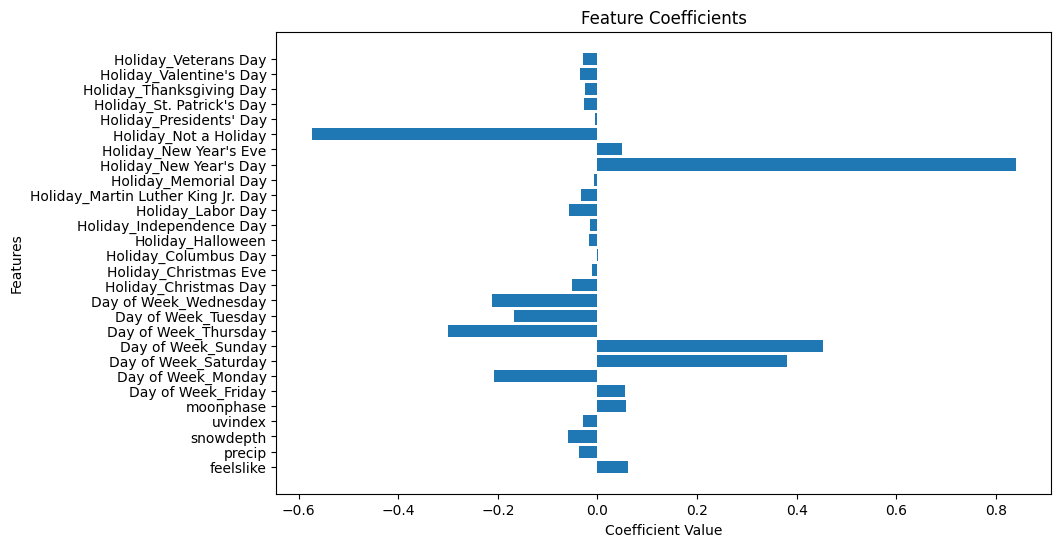

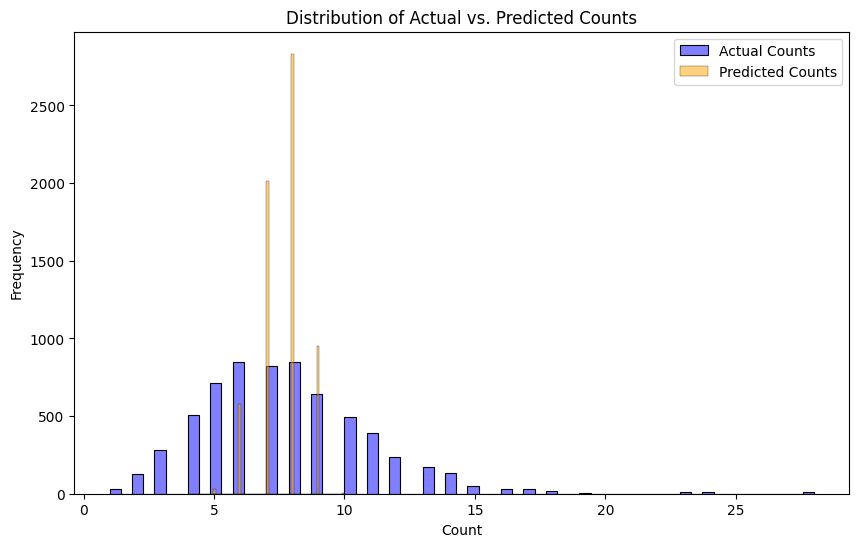

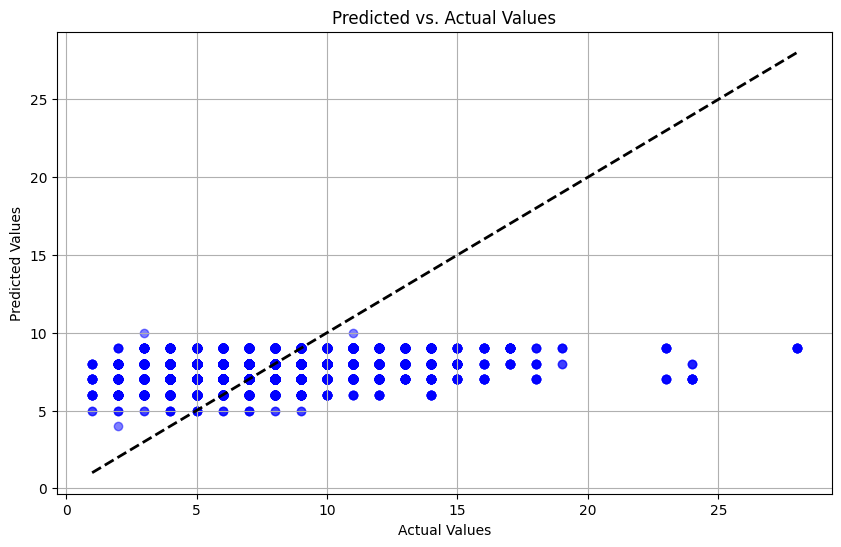

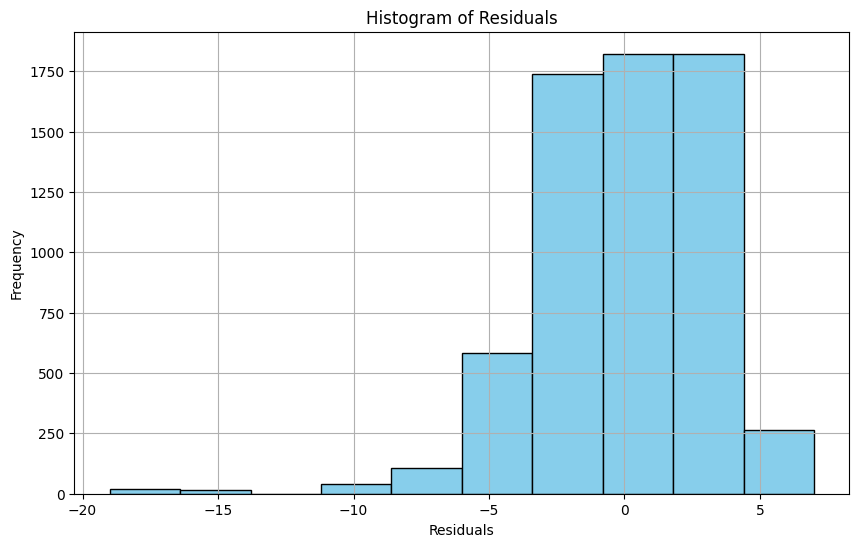

In [93]:
# Define the combined parameter grid
param_grid = {
    'alpha': [0.1, 1.0, 10.0],
    'l1_ratio': [0.0, 0.5, 1.0],
    'fit_intercept': [True, False],
}

# Initialize the ElasticNet model
elastic_net = ElasticNet(random_state=13042024)

# Perform GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=KFold(n_splits=5), scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best model
best_model = grid_search.best_estimator_

# Fit the best model to the training data
best_model.fit(X_train, y_train)

# Get predicted counts
y_pred = np.round(best_model.predict(X_test))

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

# Plot feature coefficients
coefficients = best_model.coef_
features = X.columns

plt.figure(figsize=(10, 6))
plt.barh(features, coefficients)
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Coefficients')
plt.show()

# Plot distribution of actual vs. predicted counts
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='blue', alpha=0.5, label='Actual Counts')
sns.histplot(y_pred, color='orange', alpha=0.5, label='Predicted Counts')
plt.title('Distribution of Actual vs. Predicted Counts')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot predicted vs. actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()

# Plot histogram of residuals
residuals = y_pred - y_test
plt.figure(figsize=(10, 6))
plt.hist(residuals, color='skyblue', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [94]:
mae = mean_absolute_error(y_test, y_pred)
mae

2.3303696771174542

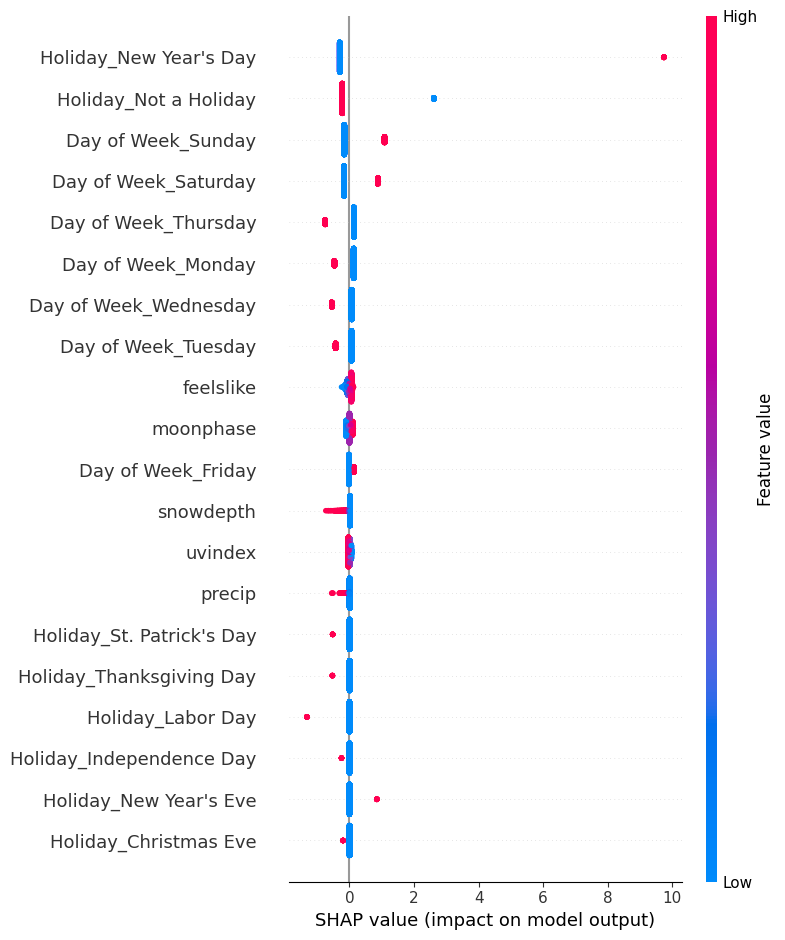

In [95]:
import shap

# Create a SHAP explainer object
explainer = shap.Explainer(best_model, X_train_scaled)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)
